# This script demonstrates a Convolutional Neural Network (CNN) for bird image classification 
(particularly distinguishing the red kite from other classes). It includes:
- Loading of training and validation data,
- Definition of the CNN model,
- Training with data augmentation,
- Evaluation and sample visualizations.

Author: Nico Klar
Date: 01.02.2025
"""

## Initialisation

In [1]:
# -*- coding: UTF-8 -*-

# python utils
import numpy as np
import os
import math

# matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from IPython import display
from IPython.display import clear_output

# tensorflow
import tensorflow as tf

from tensorflow.keras.layers import (
    Input,
    Conv2D,
    BatchNormalization,
    Activation,
    Dropout,
    MaxPooling2D,
    Flatten,
    Dense,
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-04-01 18:58:12.458543: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-01 18:58:12.477024: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-01 18:58:12.482680: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-01 18:58:12.497113: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Check for GPU Users
def configure_gpu():
    """
    (Optional) Configure GPU memory growth for TensorFlow.
    Only relevant if training on GPU.
    """
    gpus = tf.config.experimental.list_physical_devices("GPU")
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices("GPU")
            print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs.")
        except RuntimeError as e:
            print("Error setting memory growth:", e)


# Uncomment the following line if you want to enable GPU memory growth:
# configure_gpu()

print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices("GPU")))

Num GPUs Available: 1


### Helper Functions

In this section, we define auxiliary functions that will be used 
throughout the training and evaluation process.

In [3]:
def get_class_from_id(label_idx: int) -> str:
    """
    Returns the class name corresponding to the given label index.

    Parameters
    ----------
    label_idx : int
        The index representing a particular class (e.g., 0 for kite, 1 for bird, etc.)

    Returns
    -------
    str
        The class name associated with label_idx. Defaults to None if the index is not found.
    """
    label_map = {0: "kite", 1: "bird", 2: "aircraft", 3: "other"}
    return label_map.get(label_idx, None)

In [4]:
def plot_data_grid(data, targets, title_prefix="Data", grid_shape=(10, 10)):
    """
    Plots a grid of images with their dataset index and class label.

    Parameters
    ----------
    data : np.ndarray
        The data array of shape (N, H, W, [C]).
    targets : np.ndarray
        The corresponding labels; if one-hot encoded, the index is extracted via argmax.
    title_prefix : str
        A prefix for the overall plot title.
    grid_shape : tuple
        Grid dimensions, e.g. (10, 10) for 100 images.
    """

    num_images = grid_shape[0] * grid_shape[1]
    # Randomly select num_images indices from the dataset
    indices = np.random.choice(len(data), size=num_images, replace=False)

    # Create a grid of subplots
    fig, axes = plt.subplots(
        grid_shape[0], grid_shape[1], figsize=(grid_shape[1] * 2, grid_shape[0] * 2)
    )
    axes = axes.flatten()  # flatten in case it's a 2D array of axes

    for i, idx in enumerate(indices):
        ax = axes[i]
        image = data[idx]
        # Display the image (use grayscale colormap if image has one channel)
        if image.shape[-1] == 3:
            ax.imshow(image)
        else:
            ax.imshow(image.squeeze(), cmap="gray")

        # Determine the label:
        if targets.ndim > 1 and targets.shape[-1] > 1:
            label_idx = np.argmax(targets[idx])
        else:
            label_idx = targets[idx]
        label_str = get_class_from_id(int(label_idx))

        # Set title with dataset index and the corresponding label, add extra padding to avoid overlap
        ax.set_title(f"Idx {idx}\n{label_str}", fontsize=8, pad=10)
        ax.axis("off")

    # Hide any extra subplots (if any)
    for j in range(num_images, len(axes)):
        axes[j].axis("off")

    plt.suptitle(
        f"{title_prefix} Visualization ({grid_shape[0]}x{grid_shape[1]} random samples)\n",
        fontsize=12,
    )
    # Adjust layout to leave space for the suptitle:
    plt.tight_layout()
    plt.show()

In [5]:
def plot_training(
    hist_list,
    tag="Training History",
    figsize=(28, 5),
    lr_epochs=None,
    lr_values=None,
    max_val_acc_star=True,
    min_val_loss_star=True,
):
    import matplotlib.pyplot as plt
    import numpy as np

    hist_array = np.array(hist_list)
    epochs = np.arange(1, hist_array.shape[0] + 1)

    fig, axs = plt.subplots(1, 2, figsize=figsize)
    fig.subplots_adjust(wspace=0.5, right=0.8)

    # Plot Losses
    axs[0].plot(epochs, hist_array[:, 0], label="Train Loss")
    axs[0].plot(epochs, hist_array[:, 1], label="Val Loss")
    axs[0].set_title("Loss")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")

    # Plot Accuracies
    axs[1].plot(epochs, hist_array[:, 2], label="Train Accuracy")
    axs[1].plot(epochs, hist_array[:, 3], label="Val Accuracy")
    axs[1].set_title("Accuracy")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")

    # Add vertical lines at learning rate change epochs if provided
    if lr_epochs is not None and lr_values is not None:
        for epoch_val, lr in zip(lr_epochs, lr_values):
            axs[0].axvline(x=epoch_val, color="red", linestyle="--", label=f"lr: {lr}")
            axs[1].axvline(x=epoch_val, color="red", linestyle="--", label=f"lr: {lr}")

    # Add a star for maximum validation accuracy if requested
    if max_val_acc_star:
        max_val_acc_idx = np.argmax(hist_array[:, 3])
        max_val_acc = hist_array[max_val_acc_idx, 3]
        axs[1].plot(
            max_val_acc_idx + 1,
            max_val_acc,
            marker="*",
            markersize=15,
            color="gold",
            linestyle="None",
            label=f"Max Val Acc: {max_val_acc:.3f} (Epoch {max_val_acc_idx + 1})",
        )

    # Add a star for minimum validation loss if requested
    if min_val_loss_star:
        min_val_loss_idx = np.argmin(hist_array[:, 1])
        min_val_loss = hist_array[min_val_loss_idx, 1]
        axs[0].plot(
            min_val_loss_idx + 1,
            min_val_loss,
            marker="*",
            markersize=15,
            color="blue",
            linestyle="None",
            label=f"Min Val Loss: {min_val_loss:.3f} (Epoch {min_val_loss_idx + 1})",
        )

    # Place legends outside but close to each subplot
    axs[0].legend(loc="upper left", bbox_to_anchor=(1.02, 1))
    axs[1].legend(loc="upper left", bbox_to_anchor=(1.02, 1))

    fig.suptitle(tag)
    plt.show()

## Data

### Data Loading

In this section, we load the training and validation data from `.npy` files.
We assume these files contain images and labels in a compatible format (e.g., (N, H, W) arrays).
Make sure to adjust `data_path` or file names as needed for your setup.
To keep this repository lightweight, we have only included a small sample of the training and validation data. For full-scale experiments, please replace these files with your complete dataset.


In [6]:
# Paths to the our sample if .npy files
train_data_path = "./data/bird_classification_train_data.npy"
train_targets_path = "./data/bird_classification_train_targets.npy"
val_data_path = "./data/bird_classification_val_data.npy"
val_targets_path = "./data/bird_classification_val_targets.npy"

# Load the data
train_data = np.load(train_data_path)
train_targets = np.load(train_targets_path)
vali_data = np.load(val_data_path)
vali_targets = np.load(val_targets_path)

# Check Data Shapes
print("Data Shapes (before any modifications):")
print(
    "train_data Shape=%s, min=%.3f, max=%.3f"
    % (train_data.shape, train_data.min(), train_data.max())
)
print(
    "train_targets Shape=%s, min=%.3f, max=%.3f"
    % (train_targets.shape, train_targets.min(), train_targets.max())
)
print(
    "vali_data Shape=%s, min=%.3f, max=%.3f"
    % (vali_data.shape, vali_data.min(), vali_data.max())
)
print(
    "vali_targets Shape=%s, min=%.3f, max=%.3f"
    % (vali_targets.shape, vali_targets.min(), vali_targets.max())
)

Data Shapes (before any modifications):
train_data Shape=(512, 128, 128), min=9.000, max=255.000
train_targets Shape=(512, 4), min=0.000, max=1.000
vali_data Shape=(64, 128, 128), min=16.000, max=255.000
vali_targets Shape=(64, 4), min=0.000, max=1.000


### Training and Validation Data Visualization

The following plots display a grid of randomly selected images from the training and validation sets.
Above each image, the original dataset index and its corresponding class label (obtained via `get_class_from_id`)
are shown. Extra padding is added to the subplot titles to ensure they do not overlap with the global title.

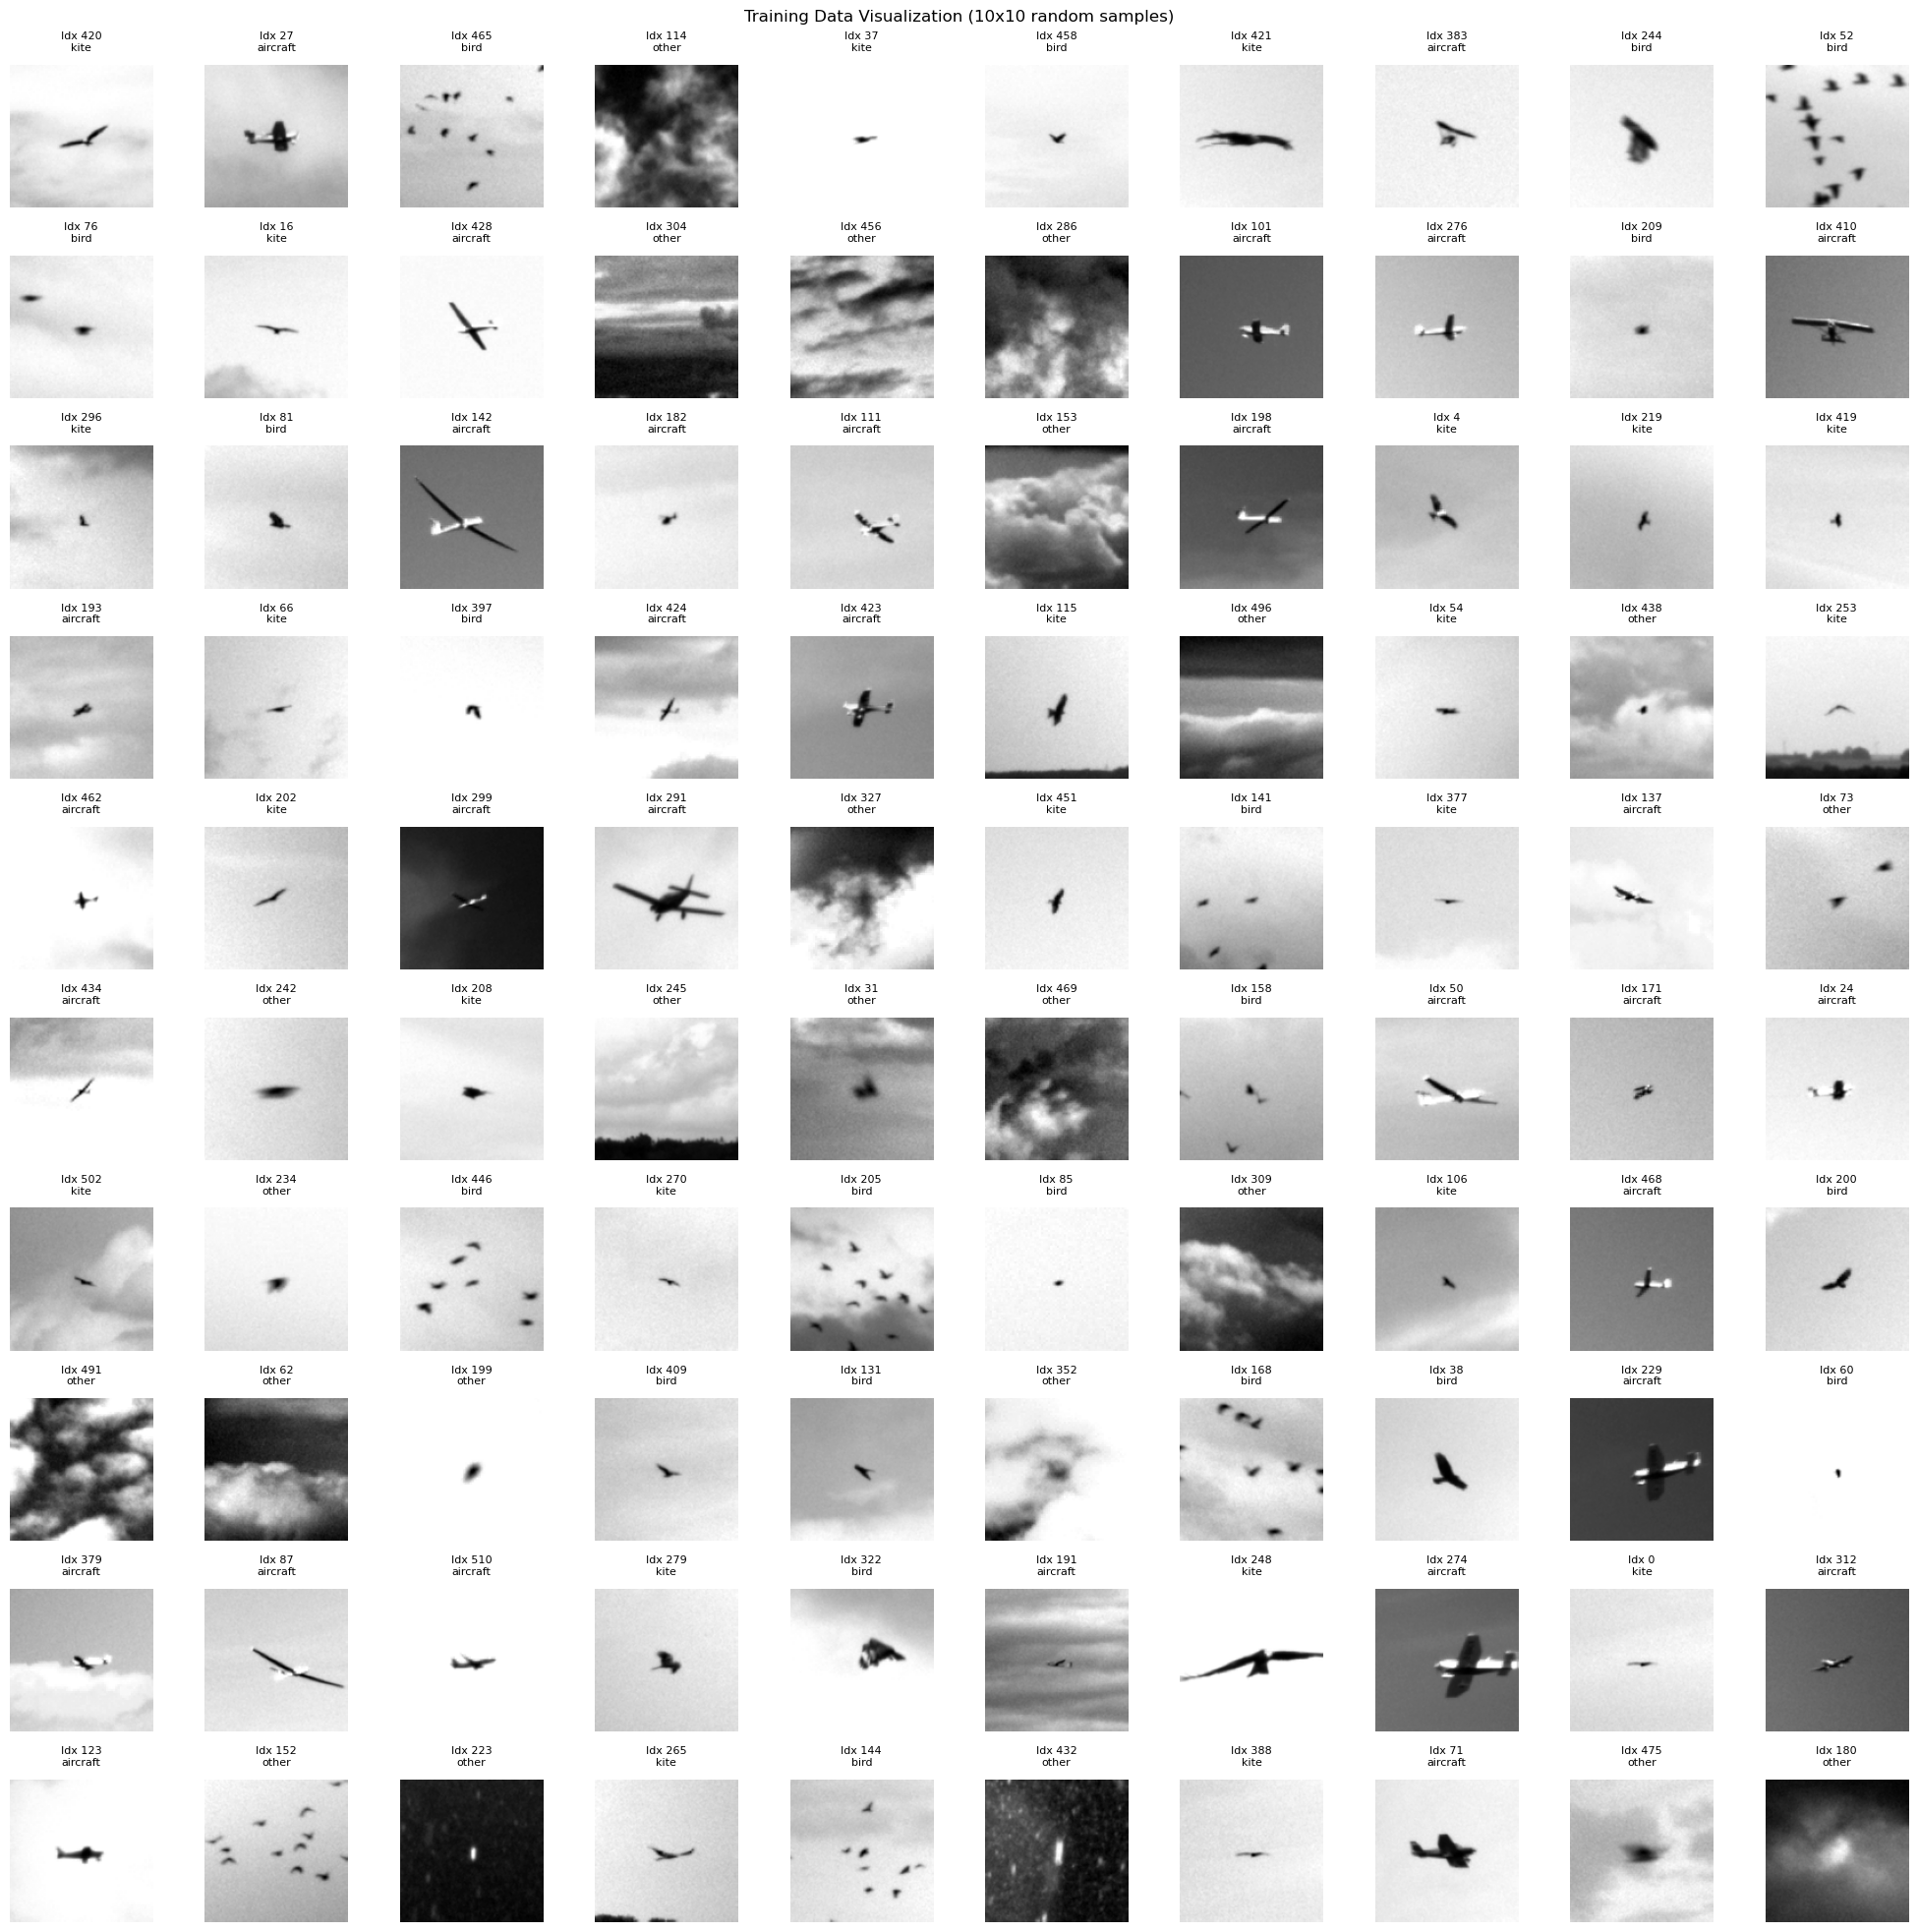

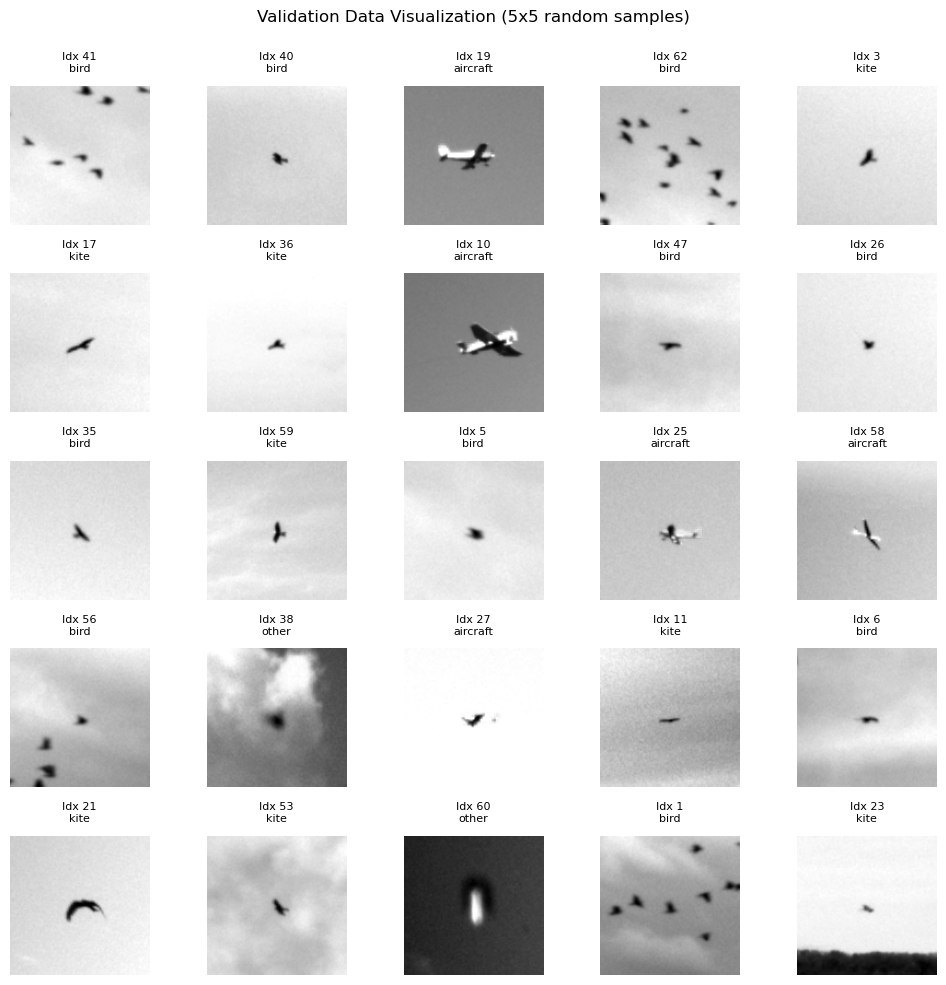

In [7]:
# Plot the training data grid
plot_data_grid(
    train_data, train_targets, title_prefix="Training Data", grid_shape=(10, 10)
)

# Plot the validation data grid
plot_data_grid(
    vali_data, vali_targets, title_prefix="Validation Data", grid_shape=(5, 5)
)

### Data Preprocessing

In this step, we prepare the data for the CNN. We assume the input images are 
originally in the shape `(N, H, W)` and contain pixel values in `[0, 255]`. 
For grayscale images, we expand the last dimension to get `(N, H, W, 1)`. 
We also normalize pixel values to `[0, 1]`. 

If you need a specific label format (e.g., a one-hot or two-column representation 
for binary classification), you can also adjust the `train_targets` and `vali_targets` below.


In [8]:
# Expand dims if your data is grayscale
train_data = np.expand_dims(train_data, axis=-1)
vali_data = np.expand_dims(vali_data, axis=-1)

# Convert the validation data to float32 and scale pixel values to [0, 1].
# (For training data, the scaling will be handled by the ImageDataGenerator)
vali_data = vali_data.astype("float32") / 255.0

# Optional: For binary classification, if your targets are [0 or 1],
# you could transform them into two columns, e.g. [label, 1-label].
# Uncomment if needed:
# train_targets = np.concatenate([train_targets, 1.0 - train_targets], axis=1)
# vali_targets = np.concatenate([vali_targets, 1.0 - vali_targets], axis=1)

# Check Data Shapes
print("Data Shapes (before any modifications):")
print(
    "train_data Shape=%s, min=%.3f, max=%.3f"
    % (train_data.shape, train_data.min(), train_data.max())
)
print(
    "train_targets Shape=%s, min=%.3f, max=%.3f"
    % (train_targets.shape, train_targets.min(), train_targets.max())
)
print(
    "vali_data Shape=%s, min=%.3f, max=%.3f"
    % (vali_data.shape, vali_data.min(), vali_data.max())
)
print(
    "vali_targets Shape=%s, min=%.3f, max=%.3f"
    % (vali_targets.shape, vali_targets.min(), vali_targets.max())
)

Data Shapes (before any modifications):
train_data Shape=(512, 128, 128, 1), min=9.000, max=255.000
train_targets Shape=(512, 4), min=0.000, max=1.000
vali_data Shape=(64, 128, 128, 1), min=0.063, max=1.000
vali_targets Shape=(64, 4), min=0.000, max=1.000


## Model

### Methodology & Training Strategy

This project uses advanced strategies for hyperparameter optimization and training control:

- **Hyperparameter Optimization using PGPE:**  
  The key hyperparameters (e.g., dropout rate, learning rate, weight decay, maximum filters) were optimized using Policy Gradients with Parameter-Based Exploration (PGPE) as described in Sehnke et al. (2008). This approach helps in efficiently exploring the parameter space.

- **Adaptive Early Stopping ("1.5x Wait Rule"):**  
  Instead of a fixed patience, the training loop dynamically extends the minimum number of epochs required after each improvement in the validation loss by a factor of 1.5. This adaptive approach allows the model additional time to converge when improvements are observed.

- **Distributed Training Support:**  
  For multi-GPU or multi-worker setups, the code supports TensorFlow’s `MultiWorkerMirroredStrategy` (or `MirroredStrategy`). When enabled, the model is created and compiled within the strategy scope to ensure proper variable distribution.

These strategies improve training efficiency and model performance while ensuring reproducibility.

### Model Configuration and Hyperparameters

We define key training parameters here, such as the dropout rate, learning rate, 
and optional data augmentation settings. Adjust these values to optimize the model performance to your dataset and usecase.


In [9]:
# Hyperparameters
dropout_rate = 0.35  # Probability to drop units in Dropout layers
learning_rate = 1e-4  # Initial learning rate
weight_decay = 1e-8  # Weight decay factor (L2 regularization)
max_filters = 512  # Maximum number of filters in certain layers (if used)

# Training parameters
batch_size = 64  # How many samples per training batch
epochs = 10  # Number of epochs for training (example value, adjust as needed)

# Data augmentation parameters (if used with ImageDataGenerator)
augmentation_params = {
    "width_shift_range": 20,
    "height_shift_range": 20,
    "rotation_range": 60,
    "shear_range": 16,
    "zoom_range": [0.5, 1.0],
    "brightness_range": [0.5, 1.0],
}

# Optional: If you have multiple learning rates you want to try in a loop:
# learning_rates = [1e-4, 1e-5, 1e-6]

print("Hyperparameters:")
print(f"  Dropout rate:        {dropout_rate}")
print(f"  Learning rate:       {learning_rate}")
print(f"  Weight decay (L2):   {weight_decay}")
print(f"  Max filters:         {max_filters}")
print(f"  Batch size:          {batch_size}")
print(f"  Epochs:              {epochs}")
print("\nData Augmentation Settings:", augmentation_params)

Hyperparameters:
  Dropout rate:        0.35
  Learning rate:       0.0001
  Weight decay (L2):   1e-08
  Max filters:         512
  Batch size:          64
  Epochs:              10

Data Augmentation Settings: {'width_shift_range': 20, 'height_shift_range': 20, 'rotation_range': 60, 'shear_range': 16, 'zoom_range': [0.5, 1.0], 'brightness_range': [0.5, 1.0]}


### Augmentation Preview

Below, we create the `ImageDataGenerator` for our training (with augmentation) 
and for our validation set (no augmentation). Then we define a helper function 
to visualize a small batch of images before and after augmentation.


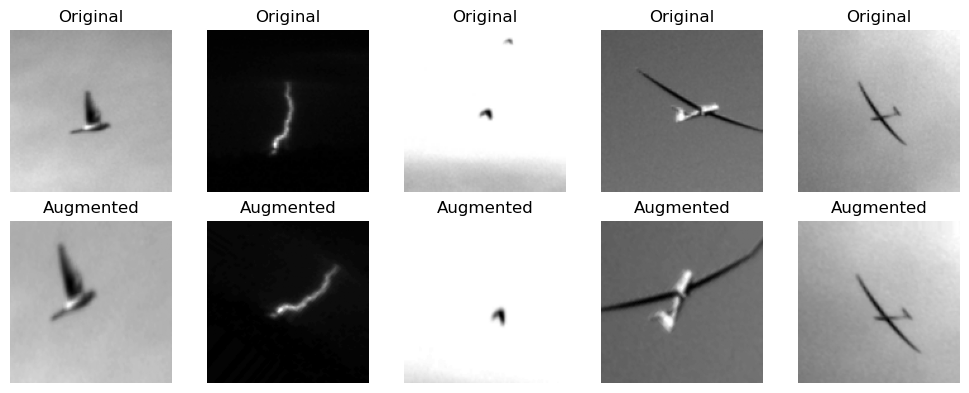

In [10]:
# 1) Create ImageDataGenerators
train_datagen = ImageDataGenerator(
    width_shift_range=augmentation_params["width_shift_range"],
    height_shift_range=augmentation_params["height_shift_range"],
    rotation_range=augmentation_params["rotation_range"],
    shear_range=augmentation_params["shear_range"],
    zoom_range=augmentation_params["zoom_range"],
    brightness_range=augmentation_params["brightness_range"],
    rescale=1.0 / 255,  # Ensures the output is normalized to [0, 1]
    # Add more params if needed, e.g. horizontal_flip=True
)

# Typically, we don't augment validation data
val_datagen = ImageDataGenerator()


# 2) Define a helper function to visualize augmented images
def preview_augmentation(data, datagen, n_samples=5, grayscale=True):
    """
    Displays a side-by-side comparison (original vs. augmented)
    for a small batch of images.

    Parameters
    ----------
    data : np.ndarray
        The original data array of shape (N, H, W, [C]).
    datagen : ImageDataGenerator
        A Keras ImageDataGenerator configured with augmentation params.
    n_samples : int
        How many images to display.
    grayscale : bool
        If True, use a 'gray' colormap; otherwise the images
        are shown in default RGB. Adjust as needed.
    """
    # Randomly pick n_samples images
    indices = np.random.choice(len(data), size=n_samples, replace=False)
    original_images = data[indices]

    # Generate one batch of augmented images from these random samples
    augmented_images = next(
        datagen.flow(original_images, batch_size=n_samples, shuffle=False)
    )

    # Create a 2-row subplot: top row = original, bottom row = augmented
    fig, axes = plt.subplots(2, n_samples, figsize=(2 * n_samples, 4))

    for i in range(n_samples):
        # Original image
        if grayscale:
            axes[0, i].imshow(original_images[i].squeeze(), cmap="gray")
        else:
            axes[0, i].imshow(original_images[i].squeeze())
        axes[0, i].set_title("Original")
        axes[0, i].axis("off")

        # Augmented image
        if grayscale:
            axes[1, i].imshow(augmented_images[i].squeeze(), cmap="gray")
        else:
            axes[1, i].imshow(augmented_images[i].squeeze())
        axes[1, i].set_title("Augmented")
        axes[1, i].axis("off")

    plt.tight_layout()
    plt.show()


# Example usage: show 5 random images before and after augmentation
preview_augmentation(train_data, train_datagen, n_samples=5, grayscale=True)

## Data Generators Initialization

We initialize two data generators using the previously configured `ImageDataGenerator` instances:
- **train_generator:** Applies data augmentation and shuffling for the training data.
- **val_generator:** Uses minimal preprocessing (no augmentation) for the validation data.

In [11]:
# Initialisation of the DataGenerators for training and validation:
train_generator = train_datagen.flow(
    train_data, train_targets, batch_size=batch_size, shuffle=True
)
val_generator = val_datagen.flow(
    vali_data, vali_targets, batch_size=batch_size, shuffle=False
)

### Model Definition

Below is a sample CNN architecture for binary bird classification. 
Adjust the layers and hyperparameters as needed for your application.

In [12]:
"""
Model Definition (with optional Distributed Strategy)

If you want to run on multiple GPUs or multiple workers, uncomment the `strategy` lines
to enable distribution. Otherwise, the code below will just use a standard single-GPU/CPU setup.
"""

# Uncomment these lines for Multi-Worker mirrored strategy:
# strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()
# print(f"Number of devices: {strategy.num_replicas_in_sync}")


def create_model(
    input_shape=(128, 128, 1),
    dropout_rate=0.35,
    weight_decay=1e-8,
    max_filters=64,
    learning_rate=1e-4,
):
    """
    Builds and compiles a simple CNN model for bird classification.

    Parameters
    ----------
    input_shape : tuple
        The shape of the input images, e.g. (height, width, channels).
    dropout_rate : float
        Dropout probability to reduce overfitting.
    weight_decay : float
        L2 regularization factor.
    max_filters : int
        Number of filters for the convolutional layers (this is an example).
    learning_rate : float
        Learning rate for the Adam optimizer.

    Returns
    -------
    model : tf.keras.Model
        A compiled Keras model ready for training.
    """

    # If using a distribution strategy, define the model inside the scope:
    # with strategy.scope():
    inputs = Input(shape=input_shape)

    # Example block: Convolution -> BatchNorm -> Activation -> MaxPooling
    x = Conv2D(
        filters=max_filters,
        kernel_size=(3, 3),
        padding="same",
        kernel_regularizer=l2(weight_decay),
    )(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Another block
    x = Conv2D(
        filters=max_filters * 2,
        kernel_size=(3, 3),
        padding="same",
        kernel_regularizer=l2(weight_decay),
    )(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Dropout to reduce overfitting
    x = Dropout(dropout_rate)(x)

    # Flatten and dense layer
    x = Flatten()(x)
    x = Dense(128, kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(dropout_rate)(x)

    # Output layer:
    # For binary classification using a single output neuron with sigmoid activation:
    # outputs = Dense(1, activation="sigmoid")(x)
    # Alternatively, for binary classification using two output neurons with softmax activation:
    # outputs = Dense(2, activation="softmax")(x)###
    # For 4-class classification (as in your current target data), use 4 output neurons with softmax activation:
    outputs = Dense(4, activation="softmax")(x)

    model = Model(inputs, outputs, name="birds_classification")

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",  # or "binary_crossentropy" if 1 output unit
        metrics=["accuracy"],
    )

    return model


# Example usage (single-GPU/CPU):
model = create_model(
    input_shape=(128, 128, 1),
    dropout_rate=0.35,
    weight_decay=1e-8,
    max_filters=64,
    learning_rate=1e-4,
)
model.summary()

# If using the MultiWorkerMirroredStrategy, comment out the above lines and do e.g.:
# with strategy.scope():
#     model = create_model(...)
# model.summary()

2025-04-01 18:58:20.965437: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30835 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3e:00.0, compute capability: 7.0


Model: "birds_classification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    16,777,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,853,636 (64.29 MB)

 Trainable params: 16,852,996 (64.29 MB)

 Non-trainable params: 640 (2.50 KB)

## Training

### Model Training

In this section, we create data generators for the training and validation sets,
and then train the model using the generators. The training history is stored
for later evaluation and visualization.


Learning Rate: 3/3 - Current epoch: 999 / min epoch: 1000


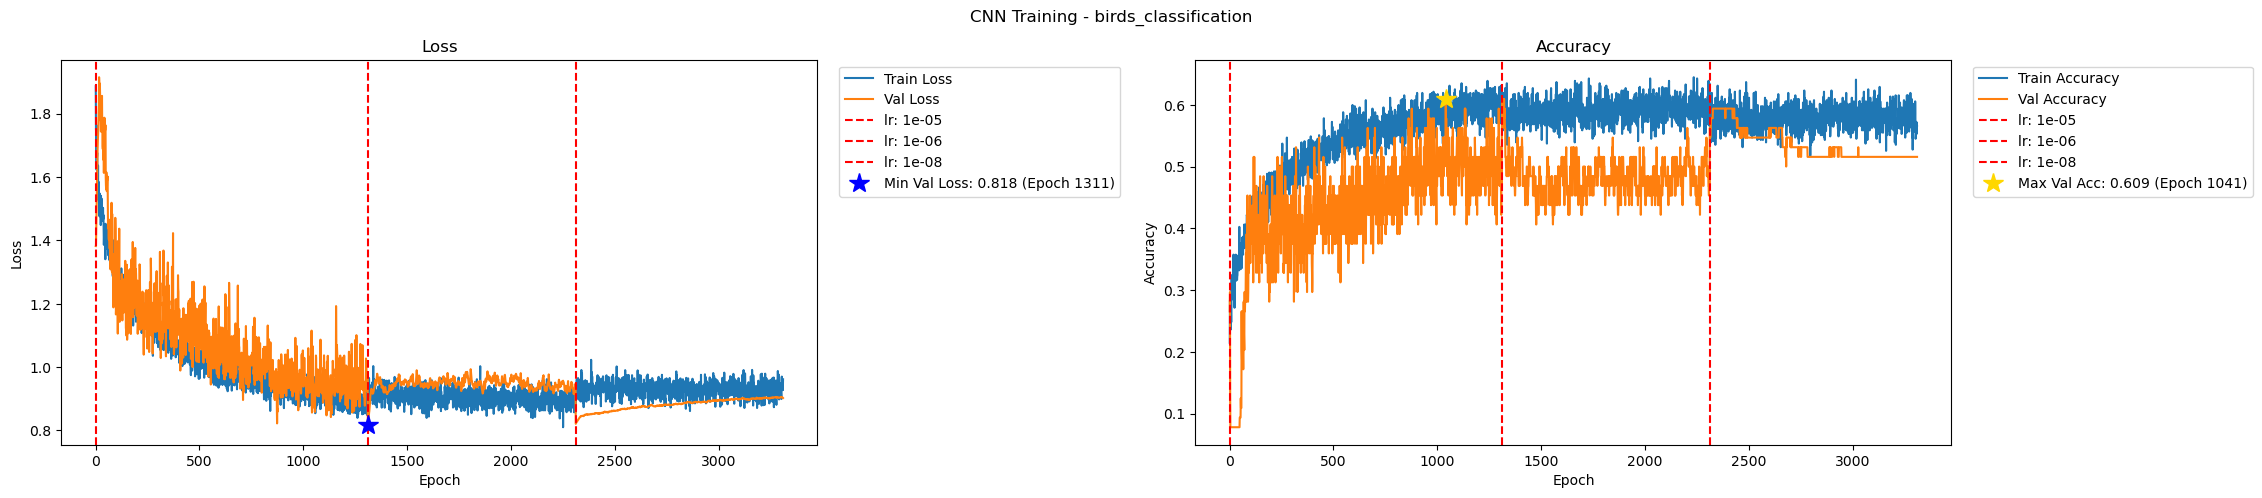

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - acc: 0.5554 - loss: 0.9635 - mae: 0.2643 - val_acc: 0.5156 - val_loss: 0.9020 - val_mae: 0.2635
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - acc: 0.6011 - loss: 0.9243 - mae: 0.2577 - val_acc: 0.5156 - val_loss: 0.9025 - val_mae: 0.2636


In [13]:
###############################################################################
#                           Helper Context (Optional)                         #
###############################################################################

from contextlib import contextmanager


@contextmanager
def dummy_context():
    yield


###############################################################################
#                     Distributed Training Setup (Optional)                   #
###############################################################################

# Reduce TensorFlow log verbosity for cleaner output
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# (Optional) Uncomment the following lines if using MultiWorker/MultiGPU training:
# strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()
# print(f"Number of devices: {strategy.num_replicas_in_sync}")


###############################################################################
#                           Model Initialization                       #
###############################################################################

# Uncomment the following lines to enable distributed training with multiple GPUs/workers:
strategy = tf.distribute.MultiWorkerMirroredStrategy()
print(f"Number of devices: {strategy.num_replicas_in_sync}")

# Alternatively, if running on a single machine with multiple GPUs, you might use:
# strategy = tf.distribute.MirroredStrategy()
print(f"Number of devices: {strategy.num_replicas_in_sync}")

# Now, create and compile your model within the strategy scope:
with strategy.scope() if "strategy" in globals() else dummy_context():
    model = create_model(
        input_shape=(128, 128, 1),
        dropout_rate=0.35,
        weight_decay=1e-8,
        max_filters=64,
        learning_rate=1e-4,
    )
    model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["acc"],
    )

# Save the initial model weights to a file (using model.name for identification)
model.save_weights(f"weights/{model.name}.weights.h5")

# Initialize best validation loss and history list
best = 10.0  # Best validation loss so far (lower is better)
hist_list = []  # List to store training history metrics


###############################################################################
#                              Training Loop                                  #
###############################################################################

# Initialize a global epoch counter and lists for tracking learning rate phases.
global_epoch = 0
lr_epochs = (
    []
)  # Records the starting global epoch for each learning rate phase (1-based).
lr_values = []  # Stores the learning rate used in each phase.

# Set a high initial threshold for the minimum epochs before switching (adaptive early stopping).
# Adaptive Early Stopping ("1.5x Wait Rule"):
# Upon each improvement in validation loss, the minimum required epochs are extended by 1.5×.
# This strategy combines aspects of EarlyStopping and ReduceLROnPlateau for flexible training continuation.
lr_list = [1e-5, 1e-6, 1e-8]  # List of learning rates for training.

try:
    # Iterate over a set of learning rates to explore different convergence behaviors.
    for i, lr in enumerate(lr_list):
        print("\nTraining with learning rate:", lr)

        # For subsequent phases, load the best saved model weights to restart training.
        if i > 0:
            model.load_weights(f"weights/{model.name}.weights.h5")

        # Record the starting epoch for the current learning rate phase.
        min_epo = 1000  # You can set this higher if needed.
        lr_epochs.append(global_epoch + 1)
        lr_values.append(lr)

        # Compile the model within the distribution strategy scope if applicable.
        # Multi-GPU/Worker setups are supported here.
        with strategy.scope() if "strategy" in globals() else dummy_context():
            model.compile(
                loss="categorical_crossentropy",
                optimizer=Adam(learning_rate=lr),
                metrics=["mae", "acc"],
            )

        # Inner training loop: run up to 100,000 epochs for this learning rate phase,
        # with early stopping based on the dynamic min_epo threshold.
        for epo in range(int(1e5)):
            if epo > min_epo:
                break  # Exit current phase if no further improvements within the threshold.

            steps_per_epoch = len(
                train_generator
            )  # Calculate steps per epoch from training generator.

            # Train for one epoch using the training generator.
            hist = model.fit(
                train_generator,
                steps_per_epoch=steps_per_epoch,
                validation_data=val_generator,
                epochs=1,
                verbose=1,
            )

            # If the current validation loss improves, update 'best' and extend 'min_epo' using the 1.5x rule.
            if hist.history["val_loss"][-1] < best:
                best = hist.history["val_loss"][-1]
                min_epo = max(min_epo, int(1.5 * epo))
                model.save_weights(f"weights/{model.name}.weights.h5")
                print("Model saved at global epoch:", global_epoch + 1)

            # Append current epoch metrics: [train_loss, val_loss, train_acc, val_acc].
            hist_list.append(
                np.array(
                    [
                        hist.history["loss"][-1],
                        hist.history["val_loss"][-1],
                        hist.history["acc"][-1],
                        hist.history["val_acc"][-1],
                    ]
                )
            )

            global_epoch += 1  # Increment the global epoch counter.

            # Every 5 global epochs, clear output and update the training plot.
            if (global_epoch) % 5 == 0:
                clear_output(wait=True)
                print(
                    f"Learning Rate: {i+1}/{len(lr_list)} - Current epoch: {epo+1} / min epoch: {min_epo}"
                )
                plot_training(
                    hist_list,
                    tag=f"CNN Training - {model.name}",
                    lr_epochs=lr_epochs,
                    lr_values=lr_values,
                )

    # After training, load the best checkpoint and save the full model (architecture + weights) in TF format.
    model.load_weights(f"weights/{model.name}.weights.h5")
    model.save(f"weights/{model.name}.full-model.h5")

except KeyboardInterrupt as e:
    # If training is manually interrupted, load the last checkpoint and save the current model state.
    print("Training interrupted:", e)
    model.load_weights(f"weights/{model.name}.weights.h5")
    model.save(f"weights/{model.name}.full-model.h5")
    print("[*] Training finished")

## Evaluation

In this section, we evaluate the trained model on the validation set. We compute the overall accuracy and display a few sample predictions, showing the true label and the model's predicted label for each image.


### Validation: Accuracy

In [20]:
# Load the best trained model
model = load_model(f"weights/{model.name}.full-model.h5", compile=False)

# Evaluate the model on the validation data
val_predictions = model.predict(vali_data, batch_size=batch_size, verbose=1)

# If the model outputs probabilities via softmax, take the argmax to obtain class indices.
predicted_indices = np.argmax(val_predictions, axis=1)

# If your true labels are one-hot encoded, convert them to class indices; otherwise, use them directly.
if vali_targets.ndim > 1 and vali_targets.shape[-1] > 1:
    true_indices = np.argmax(vali_targets, axis=1)
else:
    true_indices = vali_targets

# Compute overall validation accuracy
accuracy = np.mean(predicted_indices == true_indices)
print("Validation Accuracy: {:.2f}%".format(accuracy * 100))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
Validation Accuracy: 56.25%


### Result Analysis

In addition to the overall accuracy, we compute several additional evaluation metrics to better understand the performance of the CNN. This includes the F1 score, a detailed classification report, and visualizations of the confusion matrix and ROC curves for each class.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Validation Accuracy: 0.56
Validation F1 Score: 0.56

Classification Report:
              precision    recall  f1-score   support

        kite       0.41      0.43      0.42        21
        bird       0.69      0.47      0.56        19
    aircraft       0.58      0.74      0.65        19
       other       0.80      0.80      0.80         5

    accuracy                           0.56        64
   macro avg       0.62      0.61      0.61        64
weighted avg       0.58      0.56      0.56        64



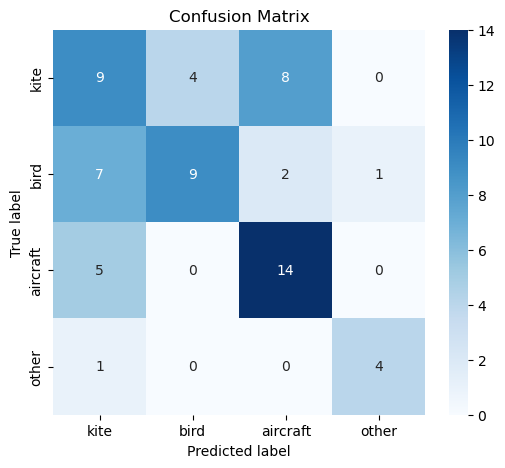

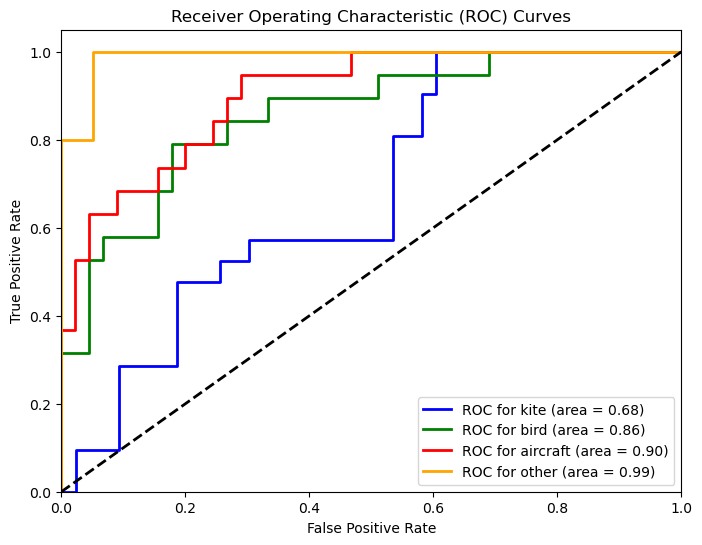

In [18]:
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    f1_score,
    roc_curve,
    auc,
)
from sklearn.preprocessing import label_binarize

# Evaluate the model on the validation data
val_predictions = model.predict(vali_data, batch_size=batch_size, verbose=1)
print("\n")

# Convert the predictions and targets to class indices
predicted_indices = np.argmax(val_predictions, axis=1)
if vali_targets.ndim > 1 and vali_targets.shape[-1] > 1:
    true_indices = np.argmax(vali_targets, axis=1)
else:
    true_indices = vali_targets

# Compute overall accuracy
accuracy = np.mean(predicted_indices == true_indices)
print("Validation Accuracy: {:.2f}".format(accuracy))

# Compute F1 score (weighted average)
f1 = f1_score(true_indices, predicted_indices, average="weighted")
print("Validation F1 Score: {:.2f}".format(f1))

# Print classification report (adjust target_names as needed)
target_names = ["kite", "bird", "aircraft", "other"]
print("\nClassification Report:")
print(
    classification_report(
        true_indices, predicted_indices, target_names=target_names, zero_division=0
    )
)


# Plot confusion matrix
cm = confusion_matrix(true_indices, predicted_indices)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=target_names,
    yticklabels=target_names,
)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix")
plt.show()

# Compute ROC curves for each class
# First, binarize the true labels (for multi-class ROC analysis)
true_binarized = label_binarize(true_indices, classes=[0, 1, 2, 3])
n_classes = true_binarized.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_binarized[:, i], val_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
colors = ["blue", "green", "red", "orange"]
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label=f"ROC for {target_names[i]} (area = {roc_auc[i]:0.2f})",
    )
plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curves")
plt.legend(loc="lower right")
plt.show()

### Validation: Sample Predictions

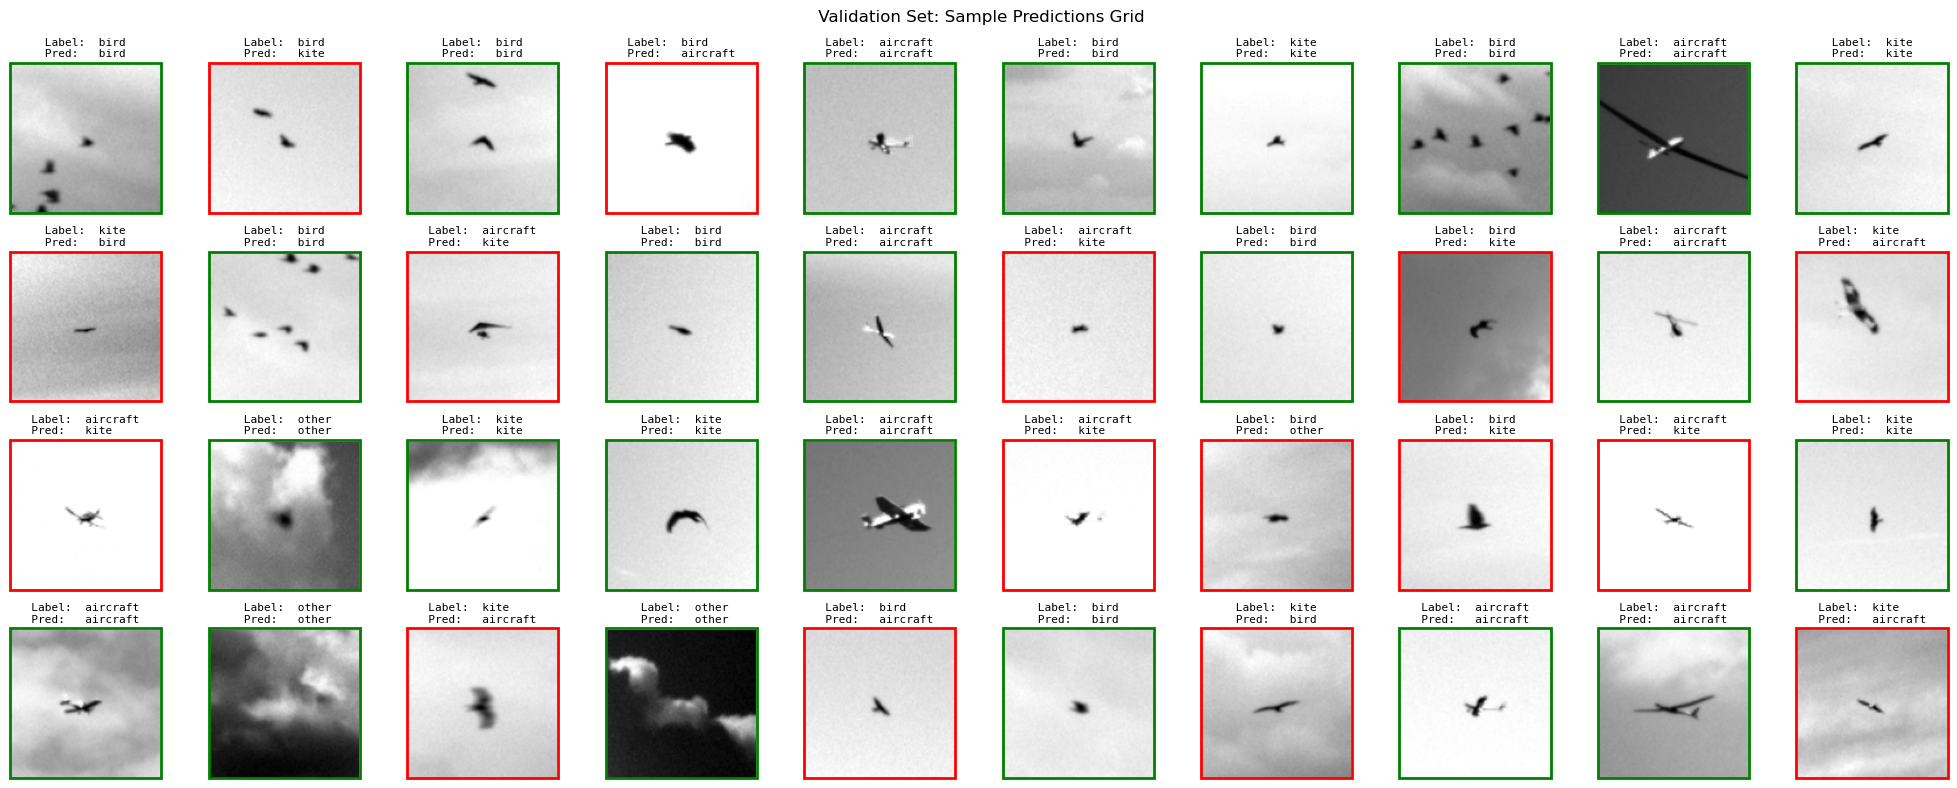

In [19]:
num_cols = 10
num_rows = 4
num_samples = num_rows * num_cols  # Total number of images

# Randomly select num_samples indices from the validation data
sample_indices = np.random.choice(len(vali_data), size=num_samples, replace=False)

# Create a grid of subplots (num_rows x num_cols)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))
axes = axes.flatten()  # Flatten the array of axes for easier iteration

for i, idx in enumerate(sample_indices):
    ax = axes[i]

    # Display the image (using grayscale if applicable)
    if vali_data.shape[-1] == 1:
        ax.imshow(vali_data[idx].squeeze(), cmap="gray")
    else:
        ax.imshow(vali_data[idx])

    # Get predicted and true labels as strings using the helper function
    pred_label = get_class_from_id(int(predicted_indices[idx]))
    true_label = get_class_from_id(int(true_indices[idx]))

    # Determine border color: green for correct predictions, red for misclassifications
    border_color = "green" if true_label == pred_label else "red"

    # Remove axis ticks and labels
    ax.axis("off")

    # Add a rectangle patch to create a visible border around the image
    rect = Rectangle(
        (-0.01, -0.0),
        1.02,
        1.01,
        linewidth=2,
        edgecolor=border_color,
        facecolor="none",
        transform=ax.transAxes,
        clip_on=False,
    )
    ax.add_patch(rect)

    # Set title with true and predicted labels, using dynamic padding for alignment.
    padding_width = 7 - (max(len(true_label), len(pred_label))) // 2
    title_text = (
        f"{' ' * padding_width}{'Label:':<8}{true_label}\n"
        f"{' ' * padding_width}{'Pred:':<8}{pred_label}"
    )
    ax.set_title(title_text, fontsize=8, loc="left", fontfamily="monospace")


plt.suptitle(
    f" Validation Set: Sample Predictions Grid",
    fontsize=12,
)

plt.tight_layout()
plt.show()